# Aplicação de Algoritmo de Detecção de Pontos de Mudança Bayesiano em SDS
Bernardo Pandolfi Costa (19207646)

## Importações iniciais e instanciando variáveis:

In [23]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## O que é o Algoritmo Bayesiano

[...]

## Datasets Utilizados
Neste trabalho, serão usados dois exemplos de casos, cada um com um total de 400 requisições, 100 para cada configuração do sistema. O objetivo da aplicação do algoritmo Bayesiano é detectar os pontos em que houve a alteração na composição do Distributor, como por exemplo mudando do Local para o Sharding.

### Primeiro Dataset: 2 Itens

O primeiro Dataset consta com o sistema em que a lista de tamanho 2. O sistema inicia na composição `propagate`, e alterna entre as outras composições no decorrer do experimento.

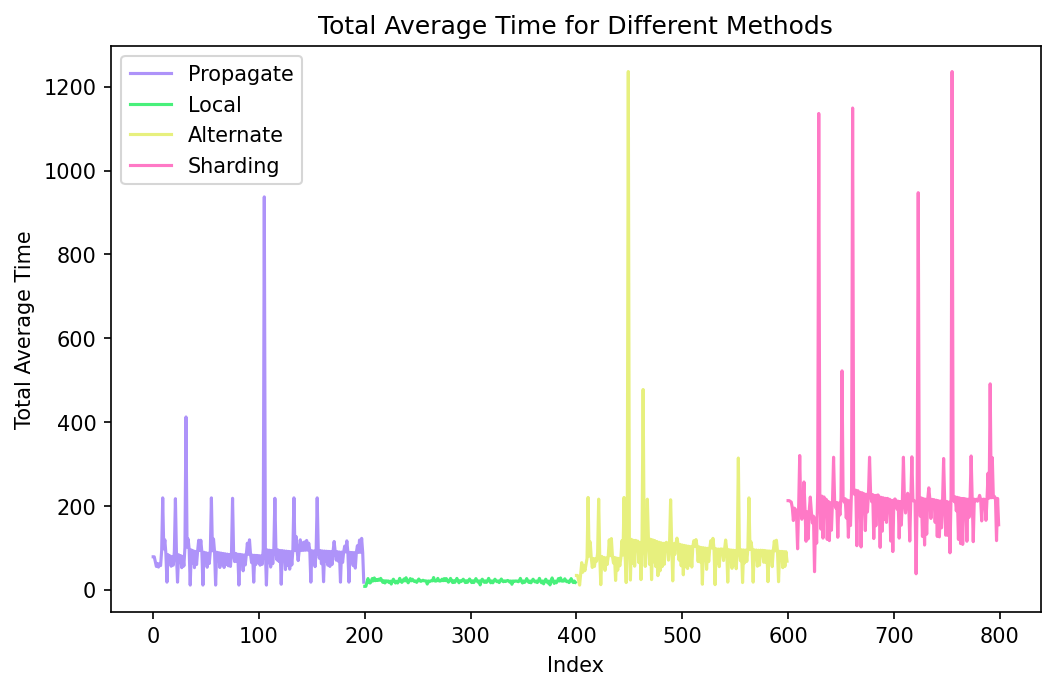

In [24]:
# Load the data
df1 = pd.read_csv('./data/propagate2itens.csv')
df2 = pd.read_csv('./data/local2itens.csv')
df3 = pd.read_csv('./data/alternate2itens.csv')
df4 = pd.read_csv('./data/sharding2itens.csv')

# Extract the third value (Total Average Time) from each CSV
total_average_time_df1 = df1.iloc[:, 2].values
total_average_time_df2 = df2.iloc[:, 2].values
total_average_time_df3 = df3.iloc[:, 2].values
total_average_time_df4 = df4.iloc[:, 2].values

plt.figure(figsize=(8,5), dpi=150)

combined_total_average_time = np.concatenate((
    total_average_time_df1, 
    total_average_time_df2, 
    total_average_time_df3, 
    total_average_time_df4
))

# Create an array of corresponding indices
indices_df1 = np.arange(len(total_average_time_df1))
indices_df2 = np.arange(len(total_average_time_df1), len(total_average_time_df1) + len(total_average_time_df2))
indices_df3 = np.arange(len(total_average_time_df1) + len(total_average_time_df2), len(total_average_time_df1) + len(total_average_time_df2) + len(total_average_time_df3))
indices_df4 = np.arange(len(total_average_time_df1) + len(total_average_time_df2) + len(total_average_time_df3), len(combined_total_average_time))

# Plot the data
plt.plot(indices_df1, total_average_time_df1, label='Propagate', color="#ae93f9")
plt.plot(indices_df2, total_average_time_df2, label='Local', color="#48f07b")
plt.plot(indices_df3, total_average_time_df3, label='Alternate', color="#e7f07e")
plt.plot(indices_df4, total_average_time_df4, label='Sharding', color="#ff79c6")

# Add title and labels
plt.title('Total Average Time for Different Methods')
plt.xlabel('Index')
plt.ylabel('Total Average Time')

# Show the legend
plt.legend()

# Show the plot
plt.show()

Em casos como este, é fácil visualizar a mudança de estados, já que existe um salto considerável entre o tempo de resposta na alteração da composição.

### Segundo Dataset: 36 Itens

O segundo dataset considera uma lista de tamanho 36. O processo aqui é o mesmo, o sistema inicia em uma configuração e a cada 200 iterações ele altera o estado.

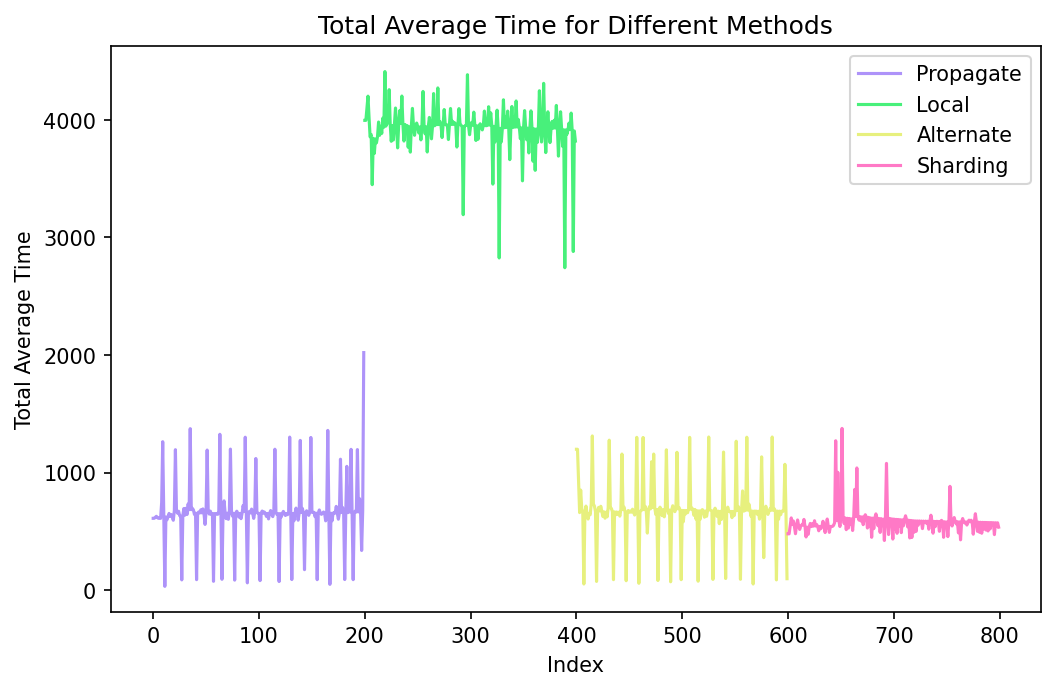

In [25]:
# Load the data
df36_1 = pd.read_csv('./data/propagate36itens.csv')
df36_2 = pd.read_csv('./data/local36itens.csv')
df36_3 = pd.read_csv('./data/alternate36itens.csv')
df36_4 = pd.read_csv('./data/sharding36itens.csv')

# Extract the third value (Total Average Time) from each CSV
total_average_time_36df1 = df36_1.iloc[:, 2].values
total_average_time_36df2 = df36_2.iloc[:, 2].values
total_average_time_36df3 = df36_3.iloc[:, 2].values
total_average_time_36df4 = df36_4.iloc[:, 2].values

plt.figure(figsize=(8,5), dpi=150)

combined36_total_average_time = np.concatenate((
    total_average_time_36df1, 
    total_average_time_36df2, 
    total_average_time_36df3, 
    total_average_time_36df4
))

# Create an array of corresponding indices
indices_df1 = np.arange(len(total_average_time_36df1))
indices_df2 = np.arange(len(total_average_time_36df1), len(total_average_time_36df1) + len(total_average_time_36df2))
indices_df3 = np.arange(len(total_average_time_36df1) + len(total_average_time_36df2), len(total_average_time_36df1) + len(total_average_time_36df2) + len(total_average_time_36df3))
indices_df4 = np.arange(len(total_average_time_36df1) + len(total_average_time_36df2) + len(total_average_time_36df3), len(combined36_total_average_time))

# Plot the data
plt.plot(indices_df1, total_average_time_36df1, label='Propagate', color="#ae93f9")
plt.plot(indices_df2, total_average_time_36df2, label='Local', color="#48f07b")
plt.plot(indices_df3, total_average_time_36df3, label='Alternate', color="#e7f07e")
plt.plot(indices_df4, total_average_time_36df4, label='Sharding', color="#ff79c6")

# Add title and labels
plt.title('Total Average Time for Different Methods')
plt.xlabel('Index')
plt.ylabel('Total Average Time')

# Show the legend
plt.legend()

# Show the plot
plt.show()

## Aplicando o Algoritmo Bayesiano - Offline
(EXPLICAR O QUE É O ALGORITMO BAYESIANO OFFLINE)
### Dataset 1

In [26]:
from bayesian_changepoint_detection.priors import const_prior
from functools import partial

from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll

prior_function = partial(const_prior, p=1/(len(combined_total_average_time) + 1))

Q, P, Pcp = offline_changepoint_detection(combined_total_average_time, prior_function ,offline_ll.StudentT(),truncate=-40)
plt.figure(figsize=(8,5), dpi=150)
plt.plot(np.exp(Pcp).sum(0))

### Dataset 2

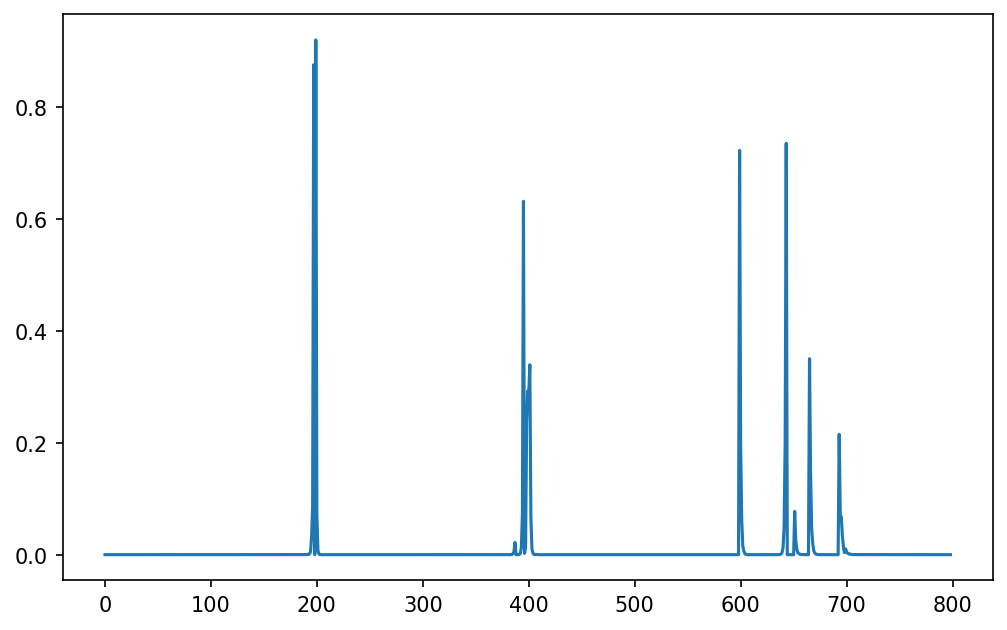

In [28]:
prior_function = partial(const_prior, p=1/(len(combined36_total_average_time) + 1))

Q, P, Pcp = offline_changepoint_detection(combined36_total_average_time, prior_function ,offline_ll.StudentT(),truncate=-40)

plt.figure(figsize=(8,5), dpi=150)
plt.plot(np.exp(Pcp).sum(0))

## Aplicando o Algoritmo Bayesiano - Online

### Dataset 1

<Figure size 1200x750 with 0 Axes>

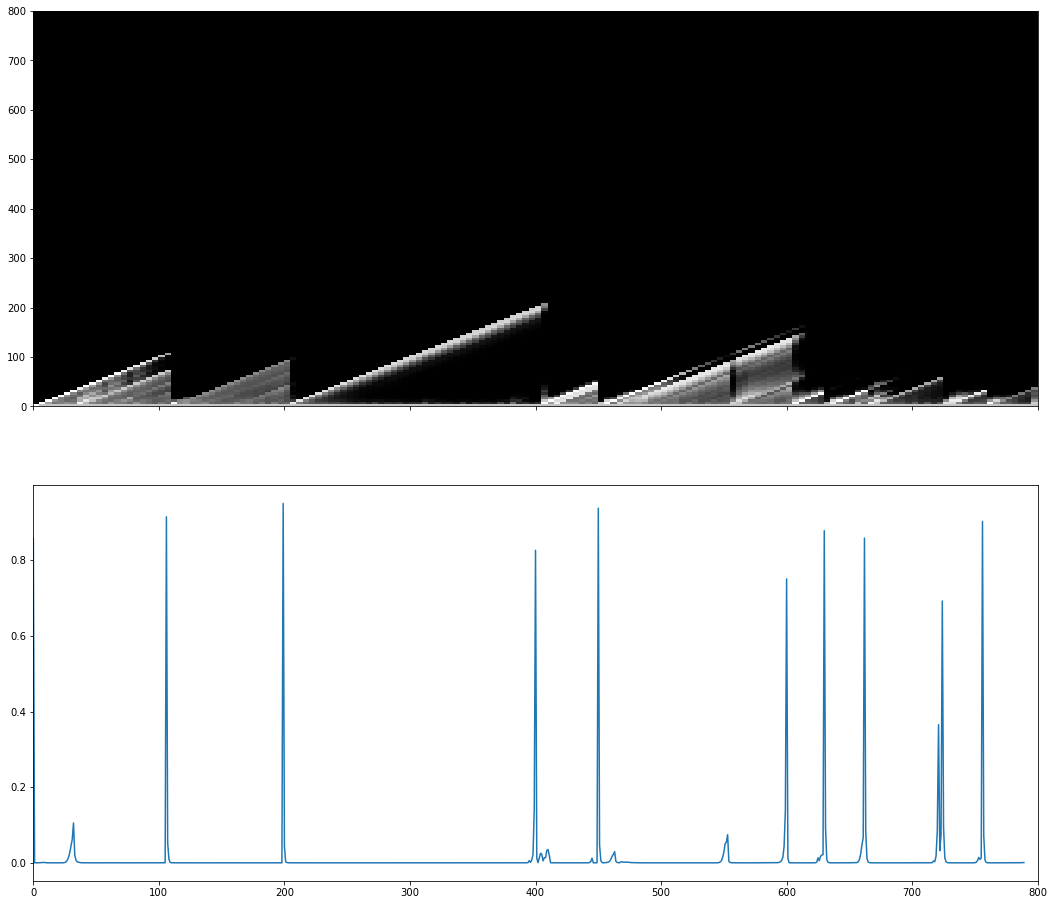

In [31]:
from bayesian_changepoint_detection.hazard_functions import constant_hazard
hazard_function = partial(constant_hazard, 250)

from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll
import matplotlib.cm as cm

R, maxes = online_changepoint_detection(
    combined_total_average_time, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

plt.figure(figsize=(8,5), dpi=150)
epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[1].plot(R[Nw,Nw:-1])

### Dataset 2

<Figure size 1200x750 with 0 Axes>

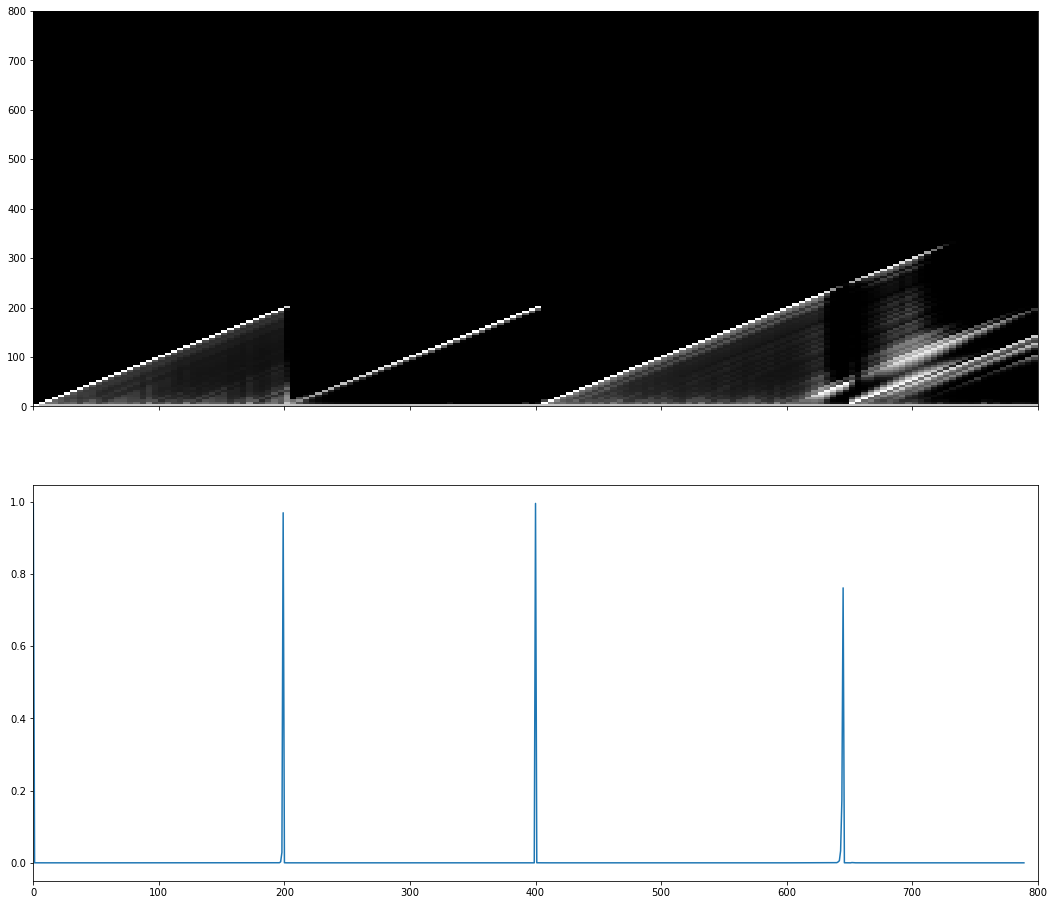

In [32]:
R, maxes = online_changepoint_detection(
    combined36_total_average_time, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

plt.figure(figsize=(8,5), dpi=150)
epsilon = 1e-7
fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[0].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[1].plot(R[Nw,Nw:-1])